In [2]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [20]:
from pathlib import Path

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import default_rng
import h5py
from scipy.stats import norm, multivariate_normal, Covariance
import cartopy.crs as ccrs
from math import ceil

from enspred.plotting import format_plot, save_plot
from enspred.kf import stack_state, unstack_state, inverse
from enspred.lab4 import plot_ensemble_mean

In [4]:
def load_dataset(year):
    path = list(Path("/glade/work/chriss/ATMS544/lab4data").glob(f"ens_*{year}.nc"))[0]
    ds = xr.open_dataset(path)
    return ds

dss = {}
for year in range(2011, 2018):
    dss[year] = load_dataset(year)

In [5]:
dss[2011]

<xarray.Dataset>
Dimensions:   (ensemble: 100, lat: 721, lon: 1440)
Coordinates:
  * lat       (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon       (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables:
    z500      (ensemble, lat, lon) float64 ...
    u500      (ensemble, lat, lon) float64 ...

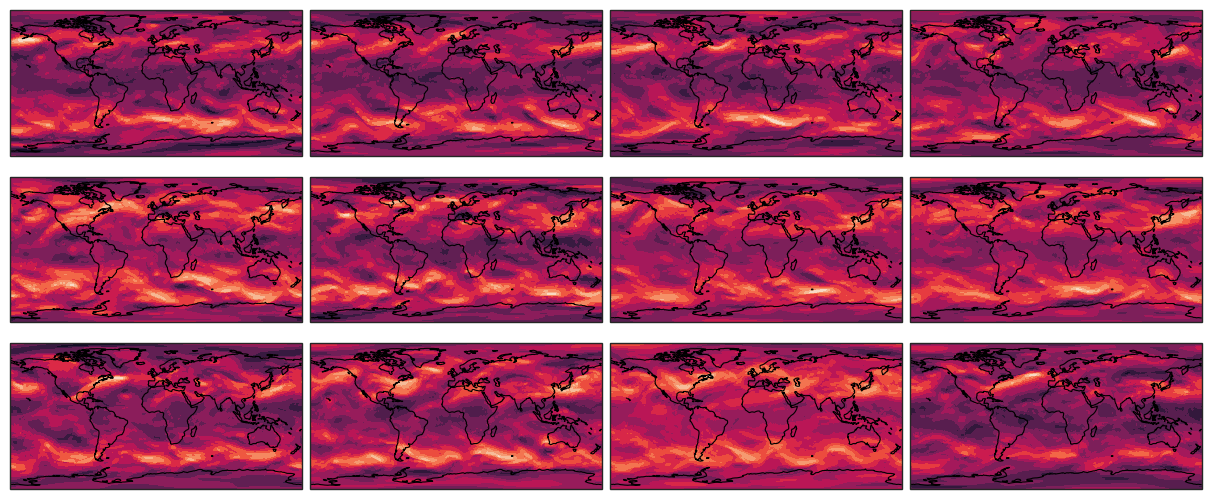

In [6]:
# ds = dss[year]
# ens_range = 12

# fig, axs = plt.subplots(int(ceil(ens_range / 4)), 4, subplot_kw=dict(projection=ccrs.PlateCarree()))

# for ax, ens in zip(axs.flat, range(ens_range)):
#     ax.contourf(ds.lon, ds.lat, ds.u500.sel(ensemble=ens*int(100 / ens_range)), 10,
#                 transform=ccrs.PlateCarree())
#     ax.coastlines()

# Experiment 1

In [63]:
obs_lat, obs_lon = 40, 200
sigma_obs = np.sqrt(10)
R = xr.DataArray([[sigma_obs**2]], coords={"ob": [0], "ob2": [0]})

In [8]:
ds = dss[year]

x_true = ds.z500.sel(lat=obs_lat, lon=obs_lon, ensemble=0).item()
x_true

5999.79612640163

In [9]:
y = x_true + norm(0, sigma_obs).rvs(random_state=default_rng(int(1415456754 + year)))
y

6000.202172271897

In [10]:
prior_samples = stack_state(ds.sel(ensemble=slice(1, None)))
prior_samples

<xarray.DataArray (elem: 2076480, ensemble: 99)>
array([[ 5.33266159e+03,  5.36206080e+03,  5.33357464e+03, ...,
         5.06426797e+03,  5.09906823e+03,  5.12065255e+03],
       [-1.52587891e-05, -6.10351562e-04,  5.79833984e-04, ...,
         9.46044922e-04, -9.46044922e-04, -7.62939453e-04],
       [ 5.33266159e+03,  5.36206080e+03,  5.33357464e+03, ...,
         5.06426797e+03,  5.09906823e+03,  5.12065255e+03],
       ...,
       [-1.52587891e-05, -6.10351562e-04,  5.79833984e-04, ...,
         9.46044922e-04, -9.46044922e-04, -7.62939453e-04],
       [ 5.12335985e+03,  5.00072033e+03,  5.02689778e+03, ...,
         5.13756052e+03,  5.18645356e+03,  5.16109598e+03],
       [-1.52587891e-05, -6.10351562e-04,  5.79833984e-04, ...,
         9.46044922e-04, -9.46044922e-04, -7.62939453e-04]])
Coordinates:
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * elem      (elem) object MultiIndex
  * lat       (elem) float64 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
  * lon       (elem) float64 0.0 0.0 0.25 0.25 0.5 ... 359.5 359.5 359.8 359.8
  * field     (elem) object 'z500' 'u500' 'z500' 'u500' ... 'u500' 'z500' 'u500'

In [11]:
x_hat = prior_samples.mean("ensemble")
x_hat

<xarray.DataArray (elem: 2076480)>
array([ 5.22241613e+03, -2.01909229e-05,  5.22241613e+03, ...,
       -2.01909229e-05,  5.05389684e+03, -2.01909229e-05])
Coordinates:
  * elem     (elem) object MultiIndex
  * lat      (elem) float64 90.0 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
  * lon      (elem) float64 0.0 0.0 0.25 0.25 0.5 ... 359.5 359.5 359.8 359.8
  * field    (elem) object 'z500' 'u500' 'z500' 'u500' ... 'u500' 'z500' 'u500'

In [12]:
X = prior_samples - x_hat
X

<xarray.DataArray (elem: 2076480, ensemble: 99)>
array([[ 1.10245453e+02,  1.39644663e+02,  1.11158504e+02, ...,
        -1.58148167e+02, -1.23347899e+02, -1.01763578e+02],
       [ 4.93213384e-06, -5.90160640e-04,  6.00024907e-04, ...,
         9.66235845e-04, -9.25853999e-04, -7.42748530e-04],
       [ 1.10245453e+02,  1.39644663e+02,  1.11158504e+02, ...,
        -1.58148167e+02, -1.23347899e+02, -1.01763578e+02],
       ...,
       [ 4.93213384e-06, -5.90160640e-04,  6.00024907e-04, ...,
         9.66235845e-04, -9.25853999e-04, -7.42748530e-04],
       [ 6.94630106e+01, -5.31765154e+01, -2.69990657e+01, ...,
         8.36636827e+01,  1.32556713e+02,  1.07199138e+02],
       [ 4.93213384e-06, -5.90160640e-04,  6.00024907e-04, ...,
         9.66235845e-04, -9.25853999e-04, -7.42748530e-04]])
Coordinates:
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * elem      (elem) object MultiIndex
  * lat       (elem) float64 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
  * lon       (elem) float64 0.0 0.0 0.25 0.25 0.5 ... 359.5 359.5 359.8 359.8
  * field     (elem) object 'z500' 'u500' 'z500' 'u500' ... 'u500' 'z500' 'u500'

In [13]:
sigma_p_hat = X.sel(lat=obs_lat, lon=obs_lon, field="z500").std().item()

In [14]:
H = xr.DataArray(np.zeros((1, len(X.elem))), coords={"ob": [0], "elem": X.elem})
H.loc[dict(lat=obs_lat, lon=obs_lon, field="z500")] = 1
H.sum()

<xarray.DataArray ()>
array(1.)

In [15]:
Z = H @ X
Z

<xarray.DataArray (ob: 1, ensemble: 99)>
array([[ 3.44637539e+02,  2.80305862e+02,  2.18129591e+02,
         1.77301115e+02,  1.93786605e+02,  2.21113631e+02,
         2.25675303e+02,  2.39256789e+02,  2.57365702e+02,
         2.36629925e+02,  2.18391998e+02,  2.38659503e+02,
         2.10993219e+02,  2.08810736e+02,  9.48362359e+01,
        -6.17158460e+00, -1.97748658e+02, -1.93740472e+02,
         1.39668518e+02,  1.95471495e+01, -1.38037043e+01,
         8.85348693e+01,  1.14905441e+02,  1.55189192e+02,
         1.84458194e+02,  1.65886185e+02,  1.50531158e+02,
         1.02916718e+02,  1.95817776e+02,  2.02304699e+02,
         1.63093674e+02,  6.84194736e+01,  1.72668168e+02,
         9.75674253e+01,  1.02686962e+02,  1.06992597e+02,
         1.21580709e+02,  1.52443668e+02,  1.75713529e+02,
         1.92106241e+02,  1.75601638e+02, -7.59377671e-03,
         1.64330454e+00,  9.21110192e+01,  8.60676802e+01,
         5.62680352e+00,  2.75460027e+01,  1.50879177e+02,
         1.67612739e+02,  3.74398451e+01,  1.19406190e+02,
         4.45690500e+01,  1.85508765e+01, -1.02458059e+02,
        -4.54160577e+01, -1.84418286e+01,  1.08075278e+02,
         4.65408899e+01, -1.25788446e+02, -2.64934566e+02,
        -2.99027248e+02, -2.02081371e+02, -2.66859817e+02,
        -3.61670199e+02, -3.35880189e+02, -3.19708075e+02,
        -4.37895431e+02, -2.82733686e+02, -1.35615392e+02,
         7.31085664e+01,  1.07992852e+02,  1.56974425e+01,
        -1.16906406e+02,  8.43749718e+01,  2.87656606e+01,
        -1.34478160e+02, -4.00393042e+02, -2.53291472e+02,
        -1.72626016e+02, -2.22208712e+02, -2.23094686e+02,
        -2.52346565e+02, -1.32844383e+02, -2.95867859e+01,
        -1.13840338e+02, -1.30293972e+02, -8.47513183e+01,
        -1.79825700e+02, -1.46762340e+02, -1.08031931e+00,
         4.36161798e+01, -4.75125313e+01, -9.68594987e+01,
         4.96599171e+01, -1.17901882e+02, -2.36494995e+02,
        -1.29107763e+02, -4.09750920e+02, -4.81872002e+02]])
Coordinates:
  * ob        (ob) int64 0
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99

In [16]:
C =Z.rename({"ensemble": "ensemble1"}).T @ Z.rename({"ensemble": "ensemble2"}) / (sigma_obs**2 + sigma_p_hat**2)
C

<xarray.DataArray (ensemble1: 99, ensemble2: 99)>
array([[ 3.39551996,  2.7616961 ,  2.14910825, ..., -1.27202622,
        -4.03704551, -4.74761399],
       [ 2.7616961 ,  2.24618482,  1.74794552, ..., -1.03458377,
        -3.28347145, -3.86140185],
       [ 2.14910825,  1.74794552,  1.36022357, ..., -0.80509674,
        -2.55514558, -3.00488188],
       ...,
       [-1.27202622, -1.03458377, -0.80509674, ...,  0.47652516,
         1.51235386,  1.7785463 ],
       [-4.03704551, -3.28347145, -2.55514558, ...,  1.51235386,
         4.79977636,  5.64459463],
       [-4.74761399, -3.86140185, -3.00488188, ...,  1.7785463 ,
         5.64459463,  6.63811106]])
Coordinates:
  * ensemble1  (ensemble1) int64 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99
  * ensemble2  (ensemble2) int64 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99

In [17]:
alpha = 1 / (1 + np.sqrt(sigma_obs**2 / (sigma_obs**2 + sigma_p_hat**2)))
T = np.identity(len(X.ensemble)) - alpha * C
T

<xarray.DataArray (ensemble1: 99, ensemble2: 99)>
array([[-2.33906329, -2.71577791, -2.11337544, ...,  1.25087648,
         3.96992232,  4.66867631],
       [-2.71577791, -1.20883793, -1.71888276, ...,  1.01738195,
         3.2288778 ,  3.79719906],
       [-2.11337544, -1.71888276, -0.33760739, ...,  0.79171055,
         2.51266166,  2.95492028],
       ...,
       [ 1.25087648,  1.01738195,  0.79171055, ...,  0.53139793,
        -1.48720824, -1.74897475],
       [ 3.96992232,  3.2288778 ,  2.51266166, ..., -1.48720824,
        -3.71997139, -5.55074303],
       [ 4.66867631,  3.79719906,  2.95492028, ..., -1.74897475,
        -5.55074303, -5.52774045]])
Coordinates:
  * ensemble1  (ensemble1) int64 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99
  * ensemble2  (ensemble2) int64 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99

In [18]:
Xa = (X @ T.rename({"ensemble1": "ensemble"})).rename({"ensemble2": "ensemble"})
Xa

<xarray.DataArray (elem: 2076480, ensemble: 99)>
array([[-5.67925289e+03, -4.56915847e+03, -3.55315766e+03, ...,
         2.01070779e+03,  6.75997735e+03,  7.99310956e+03],
       [-2.31248116e-03, -2.47499458e-03, -8.66723073e-04, ...,
         1.83438285e-03,  1.82939499e-03,  2.49745736e-03],
       [-5.67925289e+03, -4.56915847e+03, -3.55315766e+03, ...,
         2.01070779e+03,  6.75997735e+03,  7.99310956e+03],
       ...,
       [-2.31248116e-03, -2.47499458e-03, -8.66723073e-04, ...,
         1.83438285e-03,  1.82939499e-03,  2.49745736e-03],
       [ 7.55783421e+03,  6.03737981e+03,  4.71257560e+03, ...,
        -2.72162228e+03, -8.77061443e+03, -1.03630370e+04],
       [-2.31248116e-03, -2.47499458e-03, -8.66723073e-04, ...,
         1.83438285e-03,  1.82939499e-03,  2.49745736e-03]])
Coordinates:
  * elem      (elem) object MultiIndex
  * lat       (elem) float64 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
  * lon       (elem) float64 0.0 0.0 0.25 0.25 0.5 ... 359.5 359.5 359.8 359.8
  * field     (elem) object 'z500' 'u500' 'z500' 'u500' ... 'u500' 'z500' 'u500'
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99

In [71]:
D_hat = Z @ Z.T + R
D_hat

<xarray.DataArray (ob: 1, ob2: 1)>
array([[3462032.56531193]])
Coordinates:
  * ob       (ob) int64 0
  * ob2      (ob2) int64 0

In [81]:
D_hat.dot((H @ x_hat), dims="ob2")

<xarray.DataArray (ob: 1)>
array([1.95113471e+10])
Coordinates:
  * ob       (ob) int64 0

In [72]:
inverse(D_hat) @ (y - H @ x_hat)

<xarray.DataArray (ob2: 1)>
array([0.00010525])
Coordinates:
  * ob2      (ob2) int64 0

In [90]:
x_hat_a = (x_hat + X @ Z.T @ inverse(D_hat) @ (y - H @ x_hat)).squeeze()
x_hat_a

<xarray.DataArray (elem: 2076480)>
array([5.28531176e+03, 4.98485985e-06, 5.28531176e+03, ...,
       4.98485985e-06, 4.97254510e+03, 4.98485985e-06])
Coordinates:
  * elem     (elem) object MultiIndex
  * lat      (elem) float64 90.0 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
  * lon      (elem) float64 0.0 0.0 0.25 0.25 0.5 ... 359.5 359.5 359.8 359.8
  * field    (elem) object 'z500' 'u500' 'z500' 'u500' ... 'u500' 'z500' 'u500'
    ob2      int64 0
    ob       int64 0

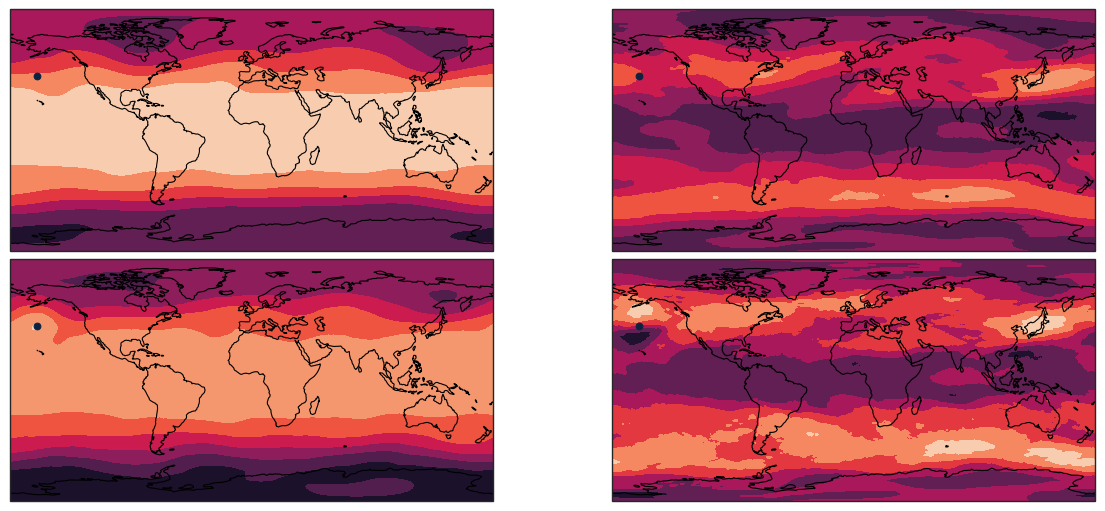

In [98]:
fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection=ccrs.PlateCarree()))
((ax_z_prior, ax_u_prior), (ax_z_post, ax_u_post)) = axs

prior_fields = unstack_state(x_hat + X)
post_fields = unstack_state(x_hat_a + Xa)

plot_ensemble_mean(ax_z_prior, prior_fields, "z500")
plot_ensemble_mean(ax_u_prior, prior_fields, "u500")
plot_ensemble_mean(ax_z_post, post_fields, "z500")
plot_ensemble_mean(ax_u_post, post_fields, "u500")

for ax in axs.flat:
    ax.coastlines()
    ax.scatter(obs_lon, obs_lat)